In [1]:
# Modifed code to work with our dataset
# Added data import and handling of our data
# Added data regularization
# updated for multiple inputs
# updated to split data evenly between different sources

In [2]:
# Import Modules
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy 

In [3]:
# Import data
df = pd.read_excel("https://raw.githubusercontent.com/adhicurry/ML_HeatTransfer_Fluids/main/FlatPlate_Models/Data_Combined_1.xlsx", engine='openpyxl')
# Replace Wall BC to numerical value
pd.set_option('future.no_silent_downcasting', True)
df['WallBC'] = df['WallBC'].replace({'UWT': 0, 'UHF': 1}).astype(float)

# Common commands
#df.describe()
df.columns
#df[['Rex', 'Nux', 'Pr']]    # Access multiple columns
#df['Figure'].unique()         # List unique ones


Index(['Figure', 'WallBC', 'Pr', 'c', 'Rex', 'Nux', 'Dataset_Label',
       'data_name_lienhard', 'Dataset author and year', 'Fluid'],
      dtype='object')

In [4]:
# Actual data used for ANN development

# data_subset = df[df['Figure'].isin([2])]   # One figure only
# data_subset = df[df['Figure'].isin([2, 3, '4a', '4b', '4c'])]  ## Air only
data_subset = df[df['Figure'].isin([2, 3, '4a', '4b', '4c', '4d', '6a','6b', 8 , '9a'])]  ## Air Water and Oil (except Fig 9b)

data_subset = data_subset.reset_index(drop=True)

#data_subset.info()
#data_subset.describe()

## ANN Code

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Using device: cpu


### Data split

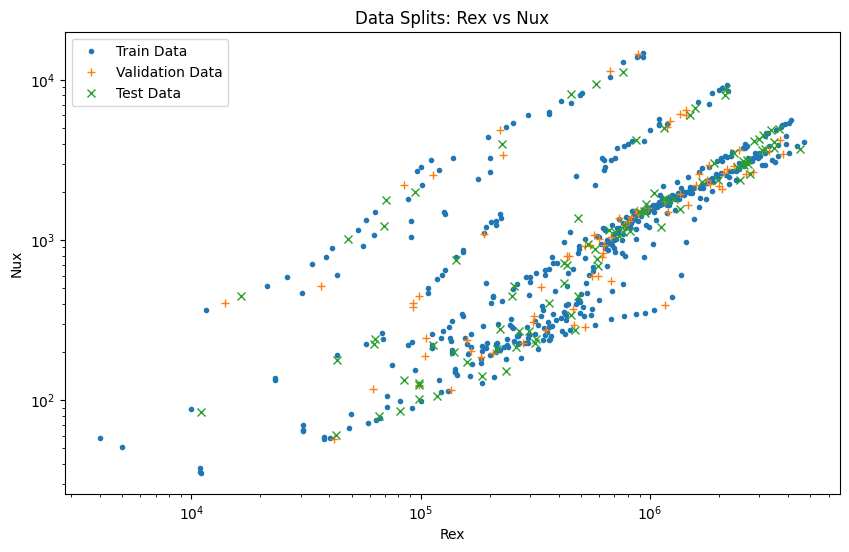

In [6]:
# Define input features and output label
X = data_subset[['Rex', 'Pr', 'WallBC', 'c']].values
y = data_subset['Nux'].values
figures = data_subset['Figure'].astype(str).values

# Split Data into training, validation, and testing
# First split: separate test data from entire data (% of data)
X_train_temp, X_test, y_train_temp, y_test, fig_train_temp, fig_test = train_test_split(
    X, y, figures,
    test_size=0.15, # CAN MODIFY THIS
    stratify=figures,
    shuffle=True,
    random_state=random_seed
)

# Second split: separate validation data from training data
X_train, X_val, y_train, y_val, fig_train, fig_val = train_test_split(
    X_train_temp, y_train_temp, fig_train_temp,
    test_size=0.15, # CAN MODIFY THIS
    stratify=fig_train_temp,
    shuffle=True,
    random_state=random_seed
)

# Initialize scalers
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit scalers on training data and transform all sets
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

# Reshape y values to 2D array for scaling
y_train_2d = y_train.reshape(-1, 1)
y_val_2d = y_val.reshape(-1, 1)
y_test_2d = y_test.reshape(-1, 1)
y_train_scaled = y_scaler.fit_transform(y_train_2d)
y_val_scaled = y_scaler.transform(y_val_2d)
y_test_scaled = y_scaler.transform(y_test_2d)

# Convert to PyTorch Tensors and move to device
X_train = torch.Tensor(X_train_scaled).float().to(device)
y_train = torch.Tensor(y_train_scaled).float().to(device)
X_val = torch.Tensor(X_val_scaled).float().to(device)
y_val = torch.Tensor(y_val_scaled).float().to(device)
X_test = torch.Tensor(X_test_scaled).float().to(device)
y_test = torch.Tensor(y_test_scaled).float().to(device)

# Save scalers for later use (important for making predictions on new data)
import joblib
joblib.dump(X_scaler, 'X_scaler.save')
joblib.dump(y_scaler, 'y_scaler.save')

# Visualize all data splits
plt.figure(figsize=(10, 6))
plt.loglog(X_scaler.inverse_transform(X_train.cpu().numpy())[:, 0], 
           y_scaler.inverse_transform(y_train.cpu().numpy()), '.', label='Train Data')
plt.loglog(X_scaler.inverse_transform(X_val.cpu().numpy())[:, 0], 
           y_scaler.inverse_transform(y_val.cpu().numpy()), '+', label='Validation Data')
plt.loglog(X_scaler.inverse_transform(X_test.cpu().numpy())[:, 0], 
           y_scaler.inverse_transform(y_test.cpu().numpy()), 'x', label='Test Data')
plt.xlabel('Rex')
plt.ylabel('Nux')
plt.title('Data Splits: Rex vs Nux')
plt.legend()
plt.show()

### Define Neural Network

In [7]:
# Define Neural Network
# Define Neural Network Architecture and Training Parameters 
# (Note to change the # of layers must be done manually in the class def below)
config = {
    'input_size': 4,         # Number of features in each input sample
    'hidden_size': 128,      # Number of neurons in the hidden layer, controls model capacity
    'output_size': 1,        # Number of output values predicted by the model
    'learning_rate': 0.001,  # Step size for gradient descent optimization
    'batch_size': 64,        # Number of samples processed in each training iteration
    'num_epochs': 1000,      # Number of complete passes through the training dataset
    'weight_decay': 0.0001,  # L2 regularization strength to prevent overfitting
    'dropout_rate': 0.15     # Fraction of neurons randomly deactivated during training
}

def predict(model, X):
    """Make predictions using the trained model."""
    model.eval()
    with torch.no_grad():
        # Convert input to tensor if it's not already
        if not isinstance(X, torch.Tensor):
            X = torch.Tensor(X).float().to(device)  # Removed .view(-1, 1) since we have multiple features
        predictions = model(X)
        return predictions.cpu().numpy().ravel()

# Define Neural Network Architecture
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)  # Added batch normalization
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
    
    def forward(self, X):
        X = self.layer1(X)
        X = self.batch_norm1(X)
        X = self.relu(X)
        X = self.dropout(X)
        
        X = self.layer2(X)
        X = self.batch_norm2(X)
        X = self.relu(X)
        X = self.dropout(X)
        
        X = self.layer3(X)
        return X
    
    def save(self, path):
        """Save model parameters."""
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        """Load model parameters."""
        self.load_state_dict(torch.load(path))

# Initialize model using config
model = NN(
    config['input_size'], 
    config['hidden_size'], 
    config['output_size'],
    config['dropout_rate']
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), 
                      lr=config['learning_rate'],
                      weight_decay=config['weight_decay'])  # Added weight_decay for L2 regularization

# Create data loaders for both training and validation
train_dataset = TensorDataset(X_train, y_train)  
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

### Run ML Model

Epoch [10/1000], Train Loss: 0.360131, Val Loss: 0.337749
Epoch [20/1000], Train Loss: 0.336835, Val Loss: 0.333193
Epoch [30/1000], Train Loss: 0.327288, Val Loss: 0.302647
Epoch [40/1000], Train Loss: 0.300683, Val Loss: 0.285155
Epoch [50/1000], Train Loss: 0.288426, Val Loss: 0.265655
Epoch [60/1000], Train Loss: 0.295271, Val Loss: 0.263055
Epoch [70/1000], Train Loss: 0.268203, Val Loss: 0.236389
Epoch [80/1000], Train Loss: 0.289665, Val Loss: 0.225931
Epoch [90/1000], Train Loss: 0.260544, Val Loss: 0.204990
Epoch [100/1000], Train Loss: 0.249297, Val Loss: 0.204313
Epoch [110/1000], Train Loss: 0.269179, Val Loss: 0.180486
Epoch [120/1000], Train Loss: 0.217006, Val Loss: 0.196109
Epoch [130/1000], Train Loss: 0.230227, Val Loss: 0.196050
Epoch [140/1000], Train Loss: 0.208994, Val Loss: 0.193629
Epoch [150/1000], Train Loss: 0.233447, Val Loss: 0.181621
Epoch [160/1000], Train Loss: 0.228157, Val Loss: 0.169976
Epoch [170/1000], Train Loss: 0.243015, Val Loss: 0.191804
Epoch 

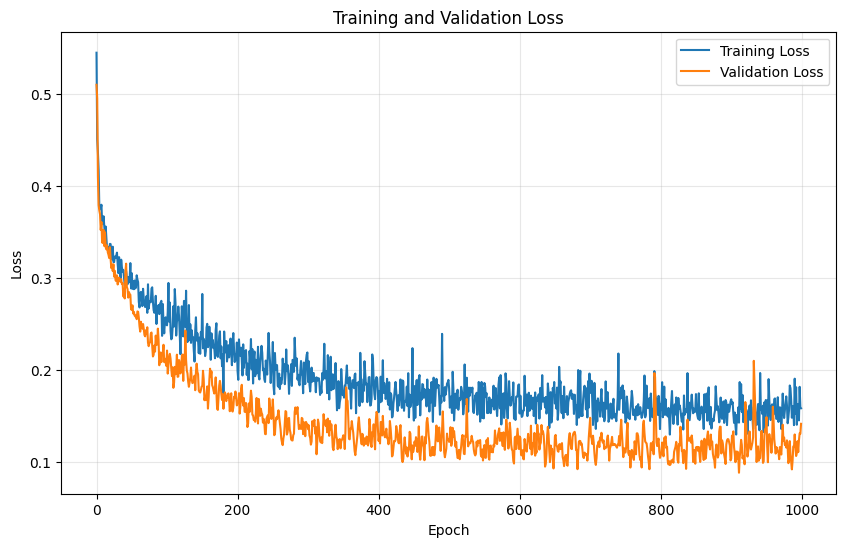

In [8]:
train_losses = []
val_losses = []

# Add variables for tracking best model and early stopping
best_val_loss = float('inf')
best_model = None
patience = 250  # Number of epochs to wait before early stopping
patience_counter = 0

for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_batches = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_batches += 1
        val_loss = val_loss / val_batches  # Average validation loss
        val_losses.append(val_loss)
        
        # Save the model if it has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0  # Reset counter
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{config["num_epochs"]}], '
              f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print(f'Best validation loss: {best_val_loss:.6f}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.yscale('log')  # Optional: use log scale for better visualization
plt.show()

Test MAE: 215.122742
Average Percentage Error: 22.54%
Minimum Error: 0.00%
Maximum Error: 188.73%
Median Error: 10.29%
68% of the data lies within an error of 18.23%
95% of the data lies within an error of 76.29%
99% of the data lies within an error of 172.06%


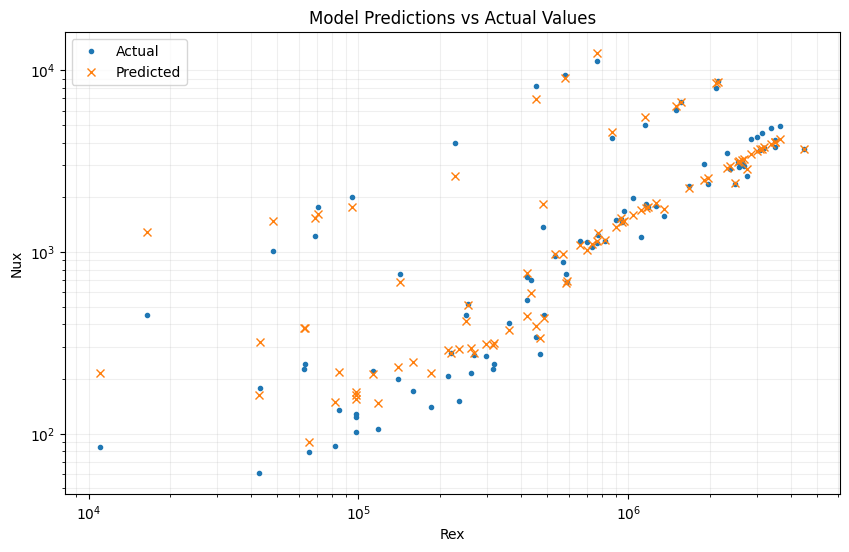

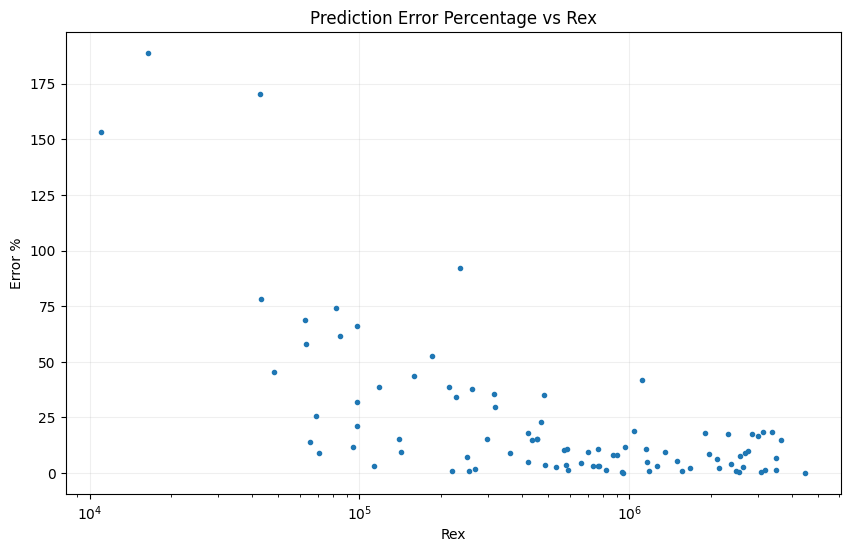

In [9]:
# Save the best model
best_model.save('best_NN_Model.pth')

# Use the best model for final evaluation
model = best_model

# Evaluate Mean Absolute Error of Model on test set
with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    
    # Transform predictions and actual values back to original scale
    predictions_original = y_scaler.inverse_transform(predictions.cpu().numpy())
    y_test_original = y_scaler.inverse_transform(y_test.cpu().numpy())
    
    # Calculate MAE on original scale
    mae = np.mean(np.abs(predictions_original - y_test_original))
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_original - predictions_original) / y_test_original)) * 100
    
    print(f'Test MAE: {mae:.6f}')
    print(f'Average Percentage Error: {mape:.2f}%')
    
    # Calculate statistics about the error distribution
    error_percentages = 100 * np.abs(predictions_original - y_test_original) / y_test_original
    print(f'Minimum Error: {np.min(error_percentages):.2f}%')
    print(f'Maximum Error: {np.max(error_percentages):.2f}%')
    print(f'Median Error: {np.median(error_percentages):.2f}%')
    
    # Calculate percentile statistics
    percentiles = [68, 95, 99]  # Can modify these percentiles as needed
    for p in percentiles:
        threshold = np.percentile(error_percentages, p)
        print(f'{p}% of the data lies within an error of {threshold:.2f}%')

# Plot predicted value vs actual value
plt.figure(figsize=(10, 6))
# Transform data back to original scale for plotting
actual_Rex = X_scaler.inverse_transform(X_test.cpu().numpy())[:, 0]  # Get Rex values and inverse transform
actual_Nux = y_scaler.inverse_transform(y_test.cpu().numpy()).ravel()
predicted_Nux = y_scaler.inverse_transform(predictions.cpu().numpy()).ravel()

plt.loglog(actual_Rex, actual_Nux, '.', label='Actual')
plt.loglog(actual_Rex, predicted_Nux, 'x', label='Predicted')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Rex')
plt.ylabel('Nux')
plt.grid(True, which="both", ls="-", alpha=0.2)  # Add grid for better readability
plt.legend()
plt.show()

# Optional: Add error percentage plot
plt.figure(figsize=(10, 6))
error_percentage = 100 * np.abs(predicted_Nux - actual_Nux) / actual_Nux
plt.semilogx(actual_Rex, error_percentage, '.')
plt.title('Prediction Error Percentage vs Rex')
plt.xlabel('Rex')
plt.ylabel('Error %')
plt.grid(True, alpha=0.2)
plt.show()

### Using ML Model with the best weights on other inputs

In [10]:
### OPTIONAL 
## Example of how to use the model for new data
# new_x = np.linspace(-np.pi, np.pi, 100)  # New data points
# predictions = predict(model, new_x)

## Example of how to load and use a saved model
# new_model = NN(config['input_size'], config['hidden_size'], config['output_size']).to(device)
# new_model.load('best_sine_model.pth')
# predictions_from_loaded = predict(new_model, new_x)